<a href="https://colab.research.google.com/github/orekhovsky/YSDA/blob/main/ML_1_course_fall2024/8_lab/hw_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt'
response = requests.get(url)

In [ ]:
response

<Response [200]>

In [ ]:
# do not change the code in the block below
# __________start of block__________
# !wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])

# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 72, 62, ..., 72, 47, 45],
       [83, 56,  1, ..., 47, 45, 56],
       [83,  1, 59, ...,  1, 57, 58],
       ...,
       [83, 66,  1, ..., 58, 53,  1],
       [83, 55, 45, ..., 50, 48, 53],
       [83, 58,  1, ...,  7,  0,  0]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# your beautiful experiments here
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Преобразуем индексы в векторы
        out, hidden = self.rnn(x, hidden)  # RNN возвращает выходы и состояние
        out = self.fc(out)  # Прогнозируем следующий токен
        return out, hidden


Epoch 1/1000, Loss: 4.4805
Epoch 2/1000, Loss: 4.2195
Epoch 3/1000, Loss: 4.8918
Epoch 4/1000, Loss: 5.6117
Epoch 5/1000, Loss: 6.3693
Epoch 6/1000, Loss: 6.8095
Epoch 7/1000, Loss: 6.5591
Epoch 8/1000, Loss: 6.1517
Epoch 9/1000, Loss: 6.4533
Epoch 10/1000, Loss: 5.7747
Epoch 11/1000, Loss: 5.4459
Epoch 12/1000, Loss: 5.1399
Epoch 13/1000, Loss: 4.4310
Epoch 14/1000, Loss: 4.5378
Epoch 15/1000, Loss: 4.1314
Epoch 16/1000, Loss: 3.9753
Epoch 17/1000, Loss: 3.9152
Epoch 18/1000, Loss: 3.8927
Epoch 19/1000, Loss: 3.6980
Epoch 20/1000, Loss: 3.5675
Epoch 21/1000, Loss: 3.5142
Epoch 22/1000, Loss: 3.3589
Epoch 23/1000, Loss: 3.2520
Epoch 24/1000, Loss: 3.1984
Epoch 25/1000, Loss: 3.1516
Epoch 26/1000, Loss: 3.0956
Epoch 27/1000, Loss: 3.1229
Epoch 28/1000, Loss: 3.0361
Epoch 29/1000, Loss: 2.9472
Epoch 30/1000, Loss: 2.9072
Epoch 31/1000, Loss: 2.9714
Epoch 32/1000, Loss: 2.9034
Epoch 33/1000, Loss: 2.8066
Epoch 34/1000, Loss: 2.8566
Epoch 35/1000, Loss: 2.8512
Epoch 36/1000, Loss: 2.7449
E

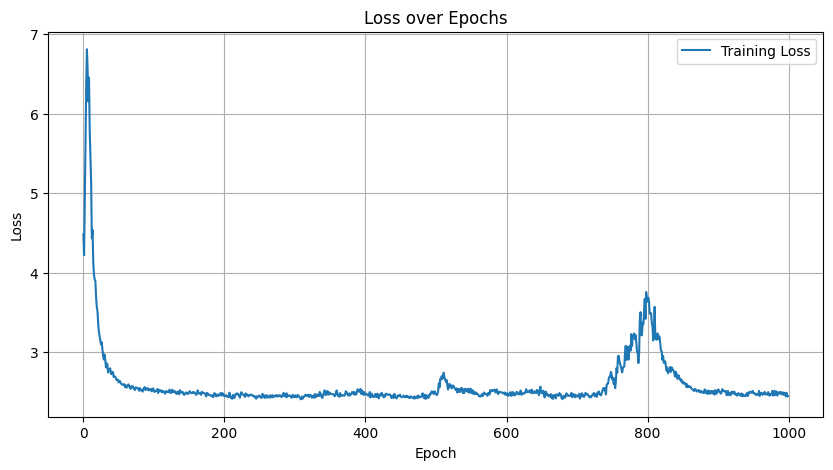

In [ ]:
num_epochs = 1000
learning_rate = 0.1

model = VanillaRNN(num_tokens, embedding_dim=128, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0  # Счетчик количества батчей

    for batch in generate_chunk():
        batch_count += 1
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]

        optimizer.zero_grad()
        output, _ = model(input_seq)
        output = output.view(-1, num_tokens)
        loss = criterion(output, target_seq.reshape(-1))  # Используем reshape для согласования форматов
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Сохраняем средний лосс за эпоху
    loss_history.append(epoch_loss / batch_count)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_history[-1]:.4f}")

# Построение графика лосса
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

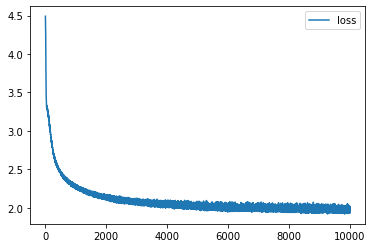

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. Higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    :param device: Device to perform computations on (e.g., 'cuda' or 'cpu')
    '''

    # Инициализируем последовательность
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Инициализируем скрытое состояние
    hidden = None

    # Генерация текста
    generated_text = seed_phrase or ""
    for _ in range(max_length - len(generated_text)):
        # Прогоняем через модель
        output, hidden = char_rnn(x_sequence, hidden)
        output = output[:, -1, :]  # Берем только последний выход

        # Применяем температуру
        probabilities = torch.softmax(output / temperature, dim=-1).squeeze().cpu().data.numpy()

        # Выбираем следующий токен
        next_token = np.random.choice(len(probabilities), p=probabilities)

        # Если токен == <eos>, прекращаем генерацию
        if tokens[next_token] == '<eos>':
            break

        # Добавляем токен в результат и обновляем x_sequence
        generated_text += tokens[next_token]
        x_sequence = torch.tensor([[next_token]], dtype=torch.int64).to(device)

    return generated_text


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правилосто она.

оте
откоходи, прехой
он мезыш нета одовна мить цер, ной мит. «ро бей.
ода?
(вихолялатся пучезви соби ста не чапретой,
кая,


тра тадена прень наличтре обили носень гепремета яетью подик пра зивы ватьям;


прасплю суший под стватно и до осочка в момно вильно хоеват понны,
евни дувье ны их посто во праска пор,
чный нотрить пона отые вы понных,
я люнувегны мою доналеши на
едоплак шале постренья,
коятовьсь мна мы;

была
вою он уг гласть прарелалаем,
доненьяма


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
# generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!